In [1]:
import pyodbc
import pandas as pd
import os 
import sqlite3 
import shutil
from sqlalchemy import create_engine
import urllib
import re

pd.set_option('display.max_columns', None)
# Database connection details
server = '#########'  
database = '#########'  
username = '#########'  
password = '#########'


# Construct the connection string
connection_string = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'
encoded_conn_str = urllib.parse.quote_plus(connection_string)

# Create the SQLAlchemy engine 
sql_engine = create_engine(f'mssql+pyodbc:///?odbc_connect={encoded_conn_str}')

query = '''
SELECT 
	[Pat_Id]
	,[Patient_Mrn]
	,[Patient_Zip_Code]
	,[Patient_Sex]
	,[Birth_Date]
FROM #########
'''
df = pd.read_sql(query, sql_engine)


# Close the connection
sql_engine.dispose() 

feature_store = sqlite3.connect('C:\\python_development\\report_csv\\feature_store.db', timeout=220) 

In [2]:
# Create feature store tables in sqlite

sqlite_db_path = 'C:\\python_development\\report_csv\\feature_store.db'

def create_tables(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # 1. Metadata for Raw Data Sources (Optional, for lineage tracking)
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS raw_data_sources (
        source_id INTEGER PRIMARY KEY AUTOINCREMENT,
        source_name TEXT UNIQUE NOT NULL,
        description TEXT,
        ingestion_timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
    )''')

    # 2. Feature Definitions (The Feature Registry)
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS feature_definitions (
        feature_id INTEGER PRIMARY KEY AUTOINCREMENT,
        feature_name TEXT UNIQUE NOT NULL,
        description TEXT,
        data_type TEXT NOT NULL, -- e.g., 'numeric', 'categorical', 'boolean'
        version INTEGER DEFAULT 1,
        created_by TEXT,
        creation_date DATETIME DEFAULT CURRENT_TIMESTAMP,
        tags TEXT, -- Comma-separated tags for easier searching
        source_transformation_id INTEGER, -- FK to feature_transformation_logic
        UNIQUE (feature_name, version)
    )''')

    # 3. Feature Transformation Logic
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS feature_transformation_logic (
        transformation_id INTEGER PRIMARY KEY AUTOINCREMENT,
        description TEXT NOT NULL, -- e.g., 'Calculated age from DateOfBirth'
        transformation_script TEXT, -- Could be Python code snippet or SQL query
        source_data_description TEXT, -- e.g., 'Input: YourRawDataTable (DateOfBirth)'
        version INTEGER DEFAULT 1,
        creation_date DATETIME DEFAULT CURRENT_TIMESTAMP
    )''')
    # Add an FK from feature_definitions.source_transformation_id to this table later if needed

    # 4. Feature Sets (Groups of features often used together, e.g., for a model)
    # The actual feature data will be stored in separate tables like 'featureset_XYZ_data'
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS engineered_feature_sets (
        feature_set_id INTEGER PRIMARY KEY AUTOINCREMENT,
        feature_set_name TEXT UNIQUE NOT NULL, -- e.g., 'patient_demographics_v1'
        description TEXT,
        target_entity TEXT, -- e.g., 'PatientID'
        timestamp_column TEXT, -- For point-in-time correctness if applicable
        sqlite_table_name TEXT UNIQUE NOT NULL, -- Name of the SQLite table storing the actual data
        creation_date DATETIME DEFAULT CURRENT_TIMESTAMP,
        version INTEGER DEFAULT 1
    )''')

    # 5. Feature Lineage (Connecting features to their transformations and sources)
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS feature_lineage (
        lineage_id INTEGER PRIMARY KEY AUTOINCREMENT,
        feature_id INTEGER NOT NULL, -- FK to feature_definitions
        transformation_id INTEGER NOT NULL, -- FK to feature_transformation_logic
        notes TEXT,
        FOREIGN KEY (feature_id) REFERENCES feature_definitions(feature_id),
        FOREIGN KEY (transformation_id) REFERENCES feature_transformation_logic(transformation_id)
    )''')

    # 6. Feature Evaluation Runs (Tracking each time features are evaluated)
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS feature_evaluation_runs (
        run_id INTEGER PRIMARY KEY AUTOINCREMENT,
        run_timestamp DATETIME DEFAULT CURRENT_TIMESTAMP,
        feature_set_id INTEGER, -- FK to engineered_feature_sets
        target_variable_name TEXT,
        model_type_evaluated_for TEXT, -- e.g., 'linear_regression', 'logistic_regression'
        notes TEXT,
        FOREIGN KEY (feature_set_id) REFERENCES engineered_feature_sets(feature_set_id)
    )''')

    # 7. Feature Evaluation Metrics (Storing the results of evaluations)
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS feature_evaluation_metrics (
        metric_id INTEGER PRIMARY KEY AUTOINCREMENT,
        run_id INTEGER NOT NULL, -- FK to feature_evaluation_runs
        feature_id INTEGER NOT NULL, -- FK to feature_definitions
        metric_name TEXT NOT NULL, -- e.g., 'pearson_correlation_with_target', 'vif', 'chi2_p_value'
        metric_value REAL, -- Using REAL for flexibility, can be TEXT for some metrics
        FOREIGN KEY (run_id) REFERENCES feature_evaluation_runs(run_id),
        FOREIGN KEY (feature_id) REFERENCES feature_definitions(feature_id)
    )''')

    conn.commit()
    conn.close()
    print(f"SQLite tables created/ensured in {db_path}")

# Call the function to create tables with the specified path
create_tables(sqlite_db_path)

SQLite tables created/ensured in C:\python_development\report_csv\feature_store.db


In [3]:
df.columns

Index(['Pat_Id', 'Patient_Mrn', 'Patient_Zip_Code', 'Patient_Sex',
       'Birth_Date'],
      dtype='object')

In [4]:
from datetime import datetime

df_engineered = df.copy()

# Feature 1: Age
def calculate_age(born_str):
    if pd.isna(born_str):
        return None

    if isinstance(born_str, str):
        born = datetime.strptime(born_str.split(' ')[0], '%Y-%m-%d') # Adjust format if needed
    elif isinstance(born_str, pd.Timestamp) or isinstance(born_str, datetime):
        born = born_str
    else:
        return None # Cannot parse
    today = datetime.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

df_engineered['Age'] = df_engineered['Birth_Date'].apply(calculate_age) # Updated column name

# Feature 2: IsSenior (Categorical from Age)
df_engineered['IsSenior'] = df_engineered['Age'].apply(lambda x: 1 if x is not None and x >= 65 else 0 if x is not None else None)

print("\nEngineered Features DataFrame:")
# Updated column name for the patient identifier
print(df_engineered[['Pat_Id', 'Age', 'IsSenior']].head())

# --- Registering features and transformations in metadata tables ---
conn = sqlite3.connect(sqlite_db_path)
cursor = conn.cursor()

# Example: Register transformation logic for 'Age'
# In a real system, you might fetch existing or insert new
# Updated description and source_data_description
cursor.execute("INSERT OR IGNORE INTO feature_transformation_logic (description, transformation_script, source_data_description) VALUES (?, ?, ?)",
               ('Calculated age from Birth_Date', 'today.year - born.year - ((today.month, today.day) < (born.month, born.day))', 'YourRawDataTable (Birth_Date)'))
conn.commit()
# It's good practice to check if insert happened or get existing id if 'IGNORE' clause is used
# For simplicity, lastrowid is used, but in robust code, you might query if not inserted.
age_transformation_id = cursor.execute("SELECT transformation_id FROM feature_transformation_logic WHERE description = ? AND source_data_description = ?",
                                       ('Calculated age from Birth_Date', 'YourRawDataTable (Birth_Date)')).fetchone()
if age_transformation_id:
    age_transformation_id = age_transformation_id[0]
else: # Fallback if IGNORE prevented lastrowid from being the one we want
    age_transformation_id = cursor.lastrowid


# Example: Register 'Age' feature definition
cursor.execute("INSERT OR IGNORE INTO feature_definitions (feature_name, description, data_type, created_by, source_transformation_id, tags) VALUES (?, ?, ?, ?, ?, ?)",
               ('Age', 'Patient age in years', 'numeric', 'D.Sarmiento', age_transformation_id, 'demographics,age'))
conn.commit()
age_feature_id = cursor.execute("SELECT feature_id FROM feature_definitions WHERE feature_name = ? AND version = 1", ('Age',)).fetchone()
if age_feature_id:
    age_feature_id = age_feature_id[0]
else:
    age_feature_id = cursor.lastrowid


# Example: Register 'IsSenior' feature definition's transformation logic
cursor.execute("INSERT OR IGNORE INTO feature_transformation_logic (description, transformation_script, source_data_description) VALUES (?, ?, ?)",
               ('Derived IsSenior (>=65) from Age', 'lambda x: 1 if x is not None and x >= 65 else 0 if x is not None else None', 'EngineeredFeatures (Age)'))
conn.commit()
issenior_transformation_id = cursor.execute("SELECT transformation_id FROM feature_transformation_logic WHERE description = ? AND source_data_description = ?",
                                       ('Derived IsSenior (>=65) from Age', 'EngineeredFeatures (Age)')).fetchone()
if issenior_transformation_id:
    issenior_transformation_id = issenior_transformation_id[0]
else:
    issenior_transformation_id = cursor.lastrowid


cursor.execute("INSERT OR IGNORE INTO feature_definitions (feature_name, description, data_type, created_by, source_transformation_id, tags) VALUES (?, ?, ?, ?, ?, ?)",
               ('IsSenior', 'Patient is 65 or older (1=Yes, 0=No)', 'boolean', 'D.Sarmiento', issenior_transformation_id, 'demographics,age,senior'))
conn.commit()
issenior_feature_id = cursor.execute("SELECT feature_id FROM feature_definitions WHERE feature_name = ? AND version = 1", ('IsSenior',)).fetchone()
if issenior_feature_id:
    issenior_feature_id = issenior_feature_id[0]
else:
    issenior_feature_id = cursor.lastrowid


# Add lineage (simplified)
if age_feature_id and age_transformation_id:
    cursor.execute("INSERT OR IGNORE INTO feature_lineage (feature_id, transformation_id) VALUES (?, ?)", (age_feature_id, age_transformation_id))
if issenior_feature_id and issenior_transformation_id:
    cursor.execute("INSERT OR IGNORE INTO feature_lineage (feature_id, transformation_id) VALUES (?, ?)", (issenior_feature_id, issenior_transformation_id))
conn.commit()
conn.close()

print("\nFeature engineering and metadata registration complete using updated column names.")


Engineered Features DataFrame:
     Pat_Id  Age  IsSenior
0  Z2775289   76         1
1  Z5484763    5         0
2  Z5073882   37         0
3  Z2849849   46         0
4  Z7208323   27         0

Feature engineering and metadata registration complete using updated column names.


In [5]:
# Storing the engineered feature set data

feature_set_name = 'patient_demographics_engineered_v1'
feature_set_sqlite_table = f"featureset_{feature_set_name}_data"

# Store the actual feature data
# Ensure PatientID is part of df_engineered for joining/identification
df_engineered_to_store = df_engineered[['Pat_Id', 'Age', 'IsSenior']] # Select relevant columns
df_engineered_to_store.to_sql(feature_set_sqlite_table, feature_store, if_exists='replace', index=False)
print(f"Stored engineered features in SQLite table: {feature_set_sqlite_table}")

# Register this feature set in metadata
conn = sqlite3.connect(sqlite_db_path)
cursor = conn.cursor()
cursor.execute("INSERT OR IGNORE INTO engineered_feature_sets (feature_set_name, description, target_entity, sqlite_table_name) VALUES (?, ?, ?, ?)",
               (feature_set_name, 'Basic demographic features including age and senior status', 'PatientID', feature_set_sqlite_table))
conn.commit()
current_feature_set_id = cursor.lastrowid # Get the ID for evaluation runs
conn.close()

Stored engineered features in SQLite table: featureset_patient_demographics_engineered_v1_data


In [6]:
# Feature evaluation logic and storing metrics

import numpy as np
from scipy.stats import pearsonr, chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assume df_final_features includes your features and a target variable ---
# For demonstration, let's create a dummy target and add it.
# In reality, you'd load this from SQL Server or another source and merge.
np.random.seed(42)
df_final_features = df_engineered_to_store.copy()
df_final_features['Target_Continuous'] = df_final_features['Age'] * 0.5 + np.random.normal(0, 5, len(df_final_features))
df_final_features['Target_Categorical'] = np.random.choice([0, 1], size=len(df_final_features), p=[0.7, 0.3])
df_final_features = df_final_features.dropna() # Drop rows with NaNs for evaluation

# --- Get Feature IDs from Metadata ---
conn = sqlite3.connect(sqlite_db_path)
cursor = conn.cursor()
def get_feature_id(feature_name):
    cursor.execute("SELECT feature_id FROM feature_definitions WHERE feature_name = ?", (feature_name,))
    result = cursor.fetchone()
    return result[0] if result else None

age_feature_id_meta = get_feature_id('Age')
issenior_feature_id_meta = get_feature_id('IsSenior')
# ... get other feature IDs

# --- Start an Evaluation Run ---
target_for_linear = 'Target_Continuous'
target_for_categorical = 'Target_Categorical'

cursor.execute("INSERT INTO feature_evaluation_runs (feature_set_id, target_variable_name, model_type_evaluated_for) VALUES (?, ?, ?)",
               (current_feature_set_id, target_for_linear, 'linear_regression'))
conn.commit()
linear_run_id = cursor.lastrowid

cursor.execute("INSERT INTO feature_evaluation_runs (feature_set_id, target_variable_name, model_type_evaluated_for) VALUES (?, ?, ?)",
               (current_feature_set_id, target_for_categorical, 'logistic_regression'))
conn.commit()
categorical_run_id = cursor.lastrowid


# --- Function to store metrics ---
def store_metric(run_id, feature_id, metric_name, metric_value):
    if feature_id is None:
        print(f"Warning: Feature ID not found for metric {metric_name}. Skipping storage.")
        return
    cursor.execute("INSERT INTO feature_evaluation_metrics (run_id, feature_id, metric_name, metric_value) VALUES (?, ?, ?, ?)",
                   (run_id, feature_id, metric_name, metric_value))
    conn.commit()

# --- Evaluating Numerical Features for Linear Regression (e.g., Age vs Target_Continuous) ---
if 'Age' in df_final_features.columns and age_feature_id_meta:
    # 1. Pearson Correlation
    corr, p_value = pearsonr(df_final_features['Age'].fillna(df_final_features['Age'].mean()),
                             df_final_features[target_for_linear])
    store_metric(linear_run_id, age_feature_id_meta, 'pearson_correlation_with_target', corr)
    store_metric(linear_run_id, age_feature_id_meta, 'pearson_p_value', p_value)
    print(f"Age vs {target_for_linear} - Pearson Correlation: {corr:.3f}, P-value: {p_value:.3f}")

    # 2. VIF (requires at least 2 features + intercept for sensible calculation)
    # For VIF, select only numeric, non-NaN columns. Add an intercept.
    numeric_features_df = df_final_features[['Age', 'Target_Continuous']].copy() # Add other numeric features here
    numeric_features_df = numeric_features_df.dropna()
    # Check if there are enough features for VIF calculation
    if numeric_features_df.shape[1] >= 2: # Need at least one feature and the target, or two features
        X_vif = numeric_features_df.drop(columns=[target_for_linear], errors='ignore')
        if 'Age' in X_vif.columns:
            # statsmodels VIF needs an intercept term typically to emulate model behavior
            from statsmodels.tools.tools import add_constant
            X_vif_const = add_constant(X_vif)
            if X_vif_const.shape[1] > 1: # Ensure there's at least one feature besides constant
                 vif_series = pd.Series([variance_inflation_factor(X_vif_const.values, i)
                                   for i in range(X_vif_const.shape[1])],
                                  index=X_vif_const.columns)
                 if 'Age' in vif_series:
                     store_metric(linear_run_id, age_feature_id_meta, 'vif', vif_series['Age'])
                     print(f"VIF for Age (with const): {vif_series['Age']:.3f}")


# --- Evaluating Categorical Features for Categorical Regression (e.g., IsSenior vs Target_Categorical) ---
if 'IsSenior' in df_final_features.columns and issenior_feature_id_meta:
    # 1. Chi-Squared Test
    contingency_table = pd.crosstab(df_final_features['IsSenior'], df_final_features[target_for_categorical])
    chi2, p_chi2, _, _ = chi2_contingency(contingency_table)
    store_metric(categorical_run_id, issenior_feature_id_meta, 'chi2_statistic', chi2)
    store_metric(categorical_run_id, issenior_feature_id_meta, 'chi2_p_value', p_chi2)
    print(f"IsSenior vs {target_for_categorical} - Chi2: {chi2:.3f}, P-value: {p_chi2:.3f}")

conn.close()

Age vs Target_Continuous - Pearson Correlation: 0.939, P-value: 0.000
VIF for Age (with const): 1.000
IsSenior vs Target_Categorical - Chi2: 2.747, P-value: 0.097


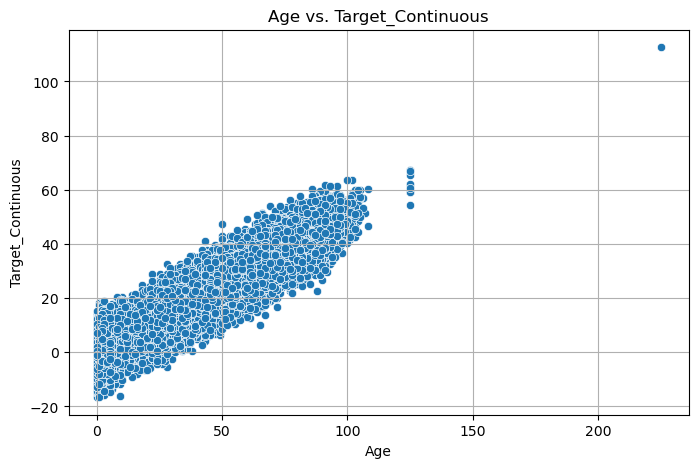

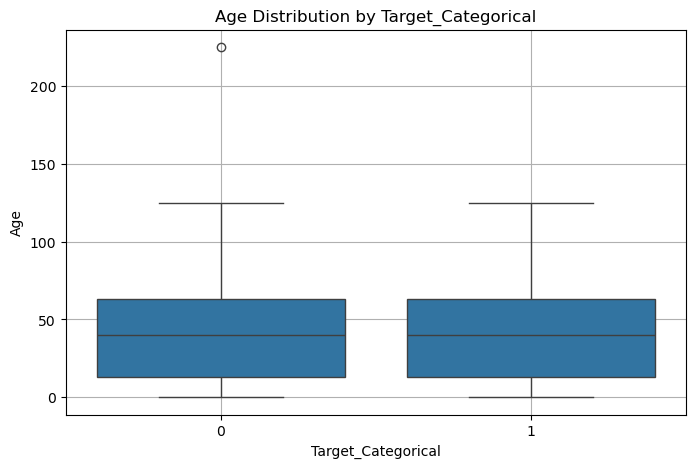

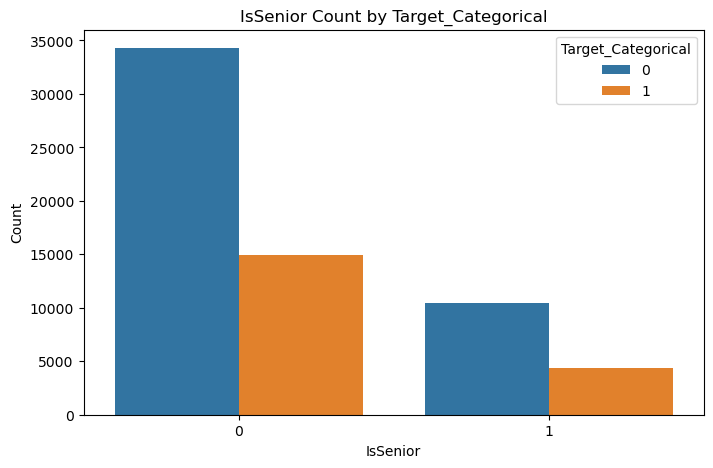

In [7]:
# Visualization for feature evaluations

# Ensure plots are displayed in Jupyter or a similar environment
# %matplotlib inline # If in Jupyter

# --- Visualizing for Linear Regression Evaluation ---
# 1. Scatter plot (Feature vs. Continuous Target)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_final_features['Age'], y=df_final_features[target_for_linear])
plt.title(f'Age vs. {target_for_linear}')
plt.xlabel('Age')
plt.ylabel(target_for_linear)
plt.grid(True)
plt.show()

# 2. Correlation Heatmap (for multiple numeric features)
# numeric_cols_for_corr = ['Age', 'SomeOtherNumericFeature', target_for_linear] # Example
# if all(col in df_final_features.columns for col in numeric_cols_for_corr):
#     correlation_matrix = df_final_features[numeric_cols_for_corr].corr()
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
#     plt.title('Feature Correlation Matrix (Linear Target)')
#     plt.show()

# --- Visualizing for Categorical Regression Evaluation ---
# 1. Box plot (Numerical Feature vs. Categorical Target)
if 'Age' in df_final_features.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df_final_features[target_for_categorical], y=df_final_features['Age'])
    plt.title(f'Age Distribution by {target_for_categorical}')
    plt.xlabel(target_for_categorical)
    plt.ylabel('Age')
    plt.grid(True)
    plt.show()

# 2. Count plot (Categorical Feature vs. Categorical Target)
if 'IsSenior' in df_final_features.columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x='IsSenior', hue=target_for_categorical, data=df_final_features)
    plt.title(f'IsSenior Count by {target_for_categorical}')
    plt.xlabel('IsSenior')
    plt.ylabel('Count')
    plt.legend(title=target_for_categorical)
    plt.show()

# 3. Bar chart for VIF scores (if calculated and stored)
# You would query VIF scores from your feature_evaluation_metrics table
# For now, if vif_series exists from above:
# if 'vif_series' in locals() and not vif_series.empty:
#     vif_df = vif_series.reset_index().rename(columns={'index':'feature', 0:'VIF'})
#     vif_df = vif_df[vif_df['feature'] != 'const'] # Exclude constant
#     plt.figure(figsize=(8,5))
#     sns.barplot(x='VIF', y='feature', data=vif_df)
#     plt.title('Variance Inflation Factor (VIF)')
#     plt.show()

In [8]:
# add evaluation for appointment no show features
df_raw = pd.read_csv('C:\\python_development\\report_csv\\no_show_prediction_dataset.csv', low_memory=False)


In [9]:
# Convert relevant columns to datetime objects, handling potential errors
date_cols_to_convert = ['CONTACT_DATE', 'APPT_MADE_DATE', 'APPT_DTTM', 'APPT_CANC_DATE', 'APPT_ARRIVAL_DTTM', 'APPT_UTC_DTTM', 'APPT_CANC_UTC_DTTM', 'APPT_MADE_UTC_DTTM']
for col in date_cols_to_convert:
    df_raw[col] = pd.to_datetime(df_raw[col], errors='coerce')

In [10]:
# --- 2. Feature Engineering ---
df_engineered = df_raw.copy()
entity_id_column = 'PAT_ENC_CSN_ID' # Primary key for these appointment features

# Feature 1: APPT_HOUR (Hour of the appointment)
def get_appt_hour(appt_dttm):
    if pd.isna(appt_dttm):
        return None
    return appt_dttm.hour
df_engineered['APPT_HOUR'] = df_engineered['APPT_DTTM'].apply(get_appt_hour)

# Feature 2: APPT_DAY_OF_WEEK (0=Monday, 6=Sunday)
def get_day_of_week(date_val):
    if pd.isna(date_val):
        return None
    return date_val.dayofweek
df_engineered['APPT_DAY_OF_WEEK'] = df_engineered['APPT_DTTM'].apply(get_day_of_week)

# Feature 3: IS_CANCELLED (Boolean)
df_engineered['IS_CANCELLED'] = df_engineered['APPT_CANC_DATE'].notna().astype(int)

# Feature 4: IS_SAME_DAY_APPT (Boolean from SAME_DAY_YN)
df_engineered['IS_SAME_DAY_APPT'] = df_engineered['SAME_DAY_YN'].apply(lambda x: 1 if x == 'Y' else 0 if x == 'N' else None)

# Feature 5: IS_CONFIRMED (Boolean from APPT_CONF_STAT_NAME)
df_engineered['IS_CONFIRMED'] = df_engineered['APPT_CONF_STAT_NAME'].apply(lambda x: 1 if x == 'Confirmed' else 0 if pd.notna(x) else None)

# Feature 6: LEAD_DAYS_GROUP (Categorical)
def group_lead_days(days):
    if pd.isna(days):
        return 'Unknown'
    if days == 0:
        return 'SameDay'
    if days <= 7:
        return '0-7Days'
    elif days <= 30:
        return '8-30Days'
    elif days <= 90:
        return '31-90Days'
    else:
        return '>90Days'
df_engineered['LEAD_DAYS_GROUP'] = df_engineered['APPT_LEAD_DAYS'].apply(group_lead_days)

In [11]:
# Hypothetical Target Variable for Evaluation
df_engineered['TARGET_LEFT_WITHOUT_SEEN'] = df_engineered['APPT_STATUS_NAME'].apply(lambda x: 1 if x == 'Left without seen' else 0)


print("\nEngineered Features DataFrame (sample):")
print(df_engineered[[entity_id_column, 'APPT_HOUR', 'APPT_DAY_OF_WEEK', 'IS_CANCELLED', 'IS_SAME_DAY_APPT', 'IS_CONFIRMED', 'LEAD_DAYS_GROUP', 'TARGET_LEFT_WITHOUT_SEEN']].head())



Engineered Features DataFrame (sample):
   PAT_ENC_CSN_ID  APPT_HOUR  APPT_DAY_OF_WEEK  IS_CANCELLED  \
0     66165956327          9                 3             0   
1     66171222971         17                 1             0   
2     66171309827         14                 3             0   
3     66156844603         15                 2             0   
4     66157000299          8                 4             0   

   IS_SAME_DAY_APPT  IS_CONFIRMED LEAD_DAYS_GROUP  TARGET_LEFT_WITHOUT_SEEN  
0                 1             1         SameDay                         1  
1                 0             1         >90Days                         1  
2                 0             0         0-7Days                         1  
3                 0             1       31-90Days                         1  
4                 0             0       31-90Days                         1  


In [12]:
# --- 3. Metadata Registration ---
# Helper function to register a feature
def register_feature(cursor, conn, feature_name, description, data_type, created_by, tags,
                     transform_desc, transform_script, transform_source_desc):
    # Register transformation logic
    cursor.execute("""
        INSERT OR IGNORE INTO feature_transformation_logic 
        (description, transformation_script, source_data_description) VALUES (?, ?, ?)
    """, (transform_desc, transform_script, transform_source_desc))
    conn.commit()
    
    transform_id_row = cursor.execute("""
        SELECT transformation_id FROM feature_transformation_logic 
        WHERE description = ? AND transformation_script = ? AND source_data_description = ?
    """, (transform_desc, transform_script, transform_source_desc)).fetchone()
    
    transformation_id = transform_id_row[0] if transform_id_row else cursor.lastrowid

    # Register feature definition
    cursor.execute("""
        INSERT OR IGNORE INTO feature_definitions 
        (feature_name, description, data_type, created_by, source_transformation_id, tags) 
        VALUES (?, ?, ?, ?, ?, ?)
    """, (feature_name, description, data_type, created_by, transformation_id, tags))
    conn.commit()

    feature_id_row = cursor.execute("""
        SELECT feature_id FROM feature_definitions WHERE feature_name = ? AND version = 1
    """, (feature_name,)).fetchone()
    feature_id = feature_id_row[0] if feature_id_row else cursor.lastrowid

    # Add lineage
    if feature_id and transformation_id:
        cursor.execute("""
            INSERT OR IGNORE INTO feature_lineage (feature_id, transformation_id) VALUES (?, ?)
        """, (feature_id, transformation_id))
        conn.commit()
    print(f"Registered feature: {feature_name}")
    return feature_id

In [13]:
# Connect to DB for registration
conn_reg = sqlite3.connect(sqlite_db_path)
cursor_reg = conn_reg.cursor()

# Register engineered features
appt_hour_fid = register_feature(
    cursor_reg, conn_reg, 'APPT_HOUR', 'Hour of the appointment (0-23)', 'numeric', 'FeatureScript', 'time,appointment',
    'Extract hour from APPT_DTTM', "appt_dttm.hour if pd.notna(appt_dttm) else None", 'RawAppointments(APPT_DTTM)'
)
appt_dow_fid = register_feature(
    cursor_reg, conn_reg, 'APPT_DAY_OF_WEEK', 'Day of week of appointment (0=Mon, 6=Sun)', 'categorical', 'FeatureScript', 'time,appointment',
    'Extract day of week from APPT_DTTM', "appt_dttm.dayofweek if pd.notna(appt_dttm) else None", 'RawAppointments(APPT_DTTM)'
)
is_cancelled_fid = register_feature(
    cursor_reg, conn_reg, 'IS_CANCELLED', 'Boolean flag if appointment was cancelled (1=Yes, 0=No)', 'boolean', 'FeatureScript', 'status,appointment',
    'Check if APPT_CANC_DATE is not NaN', "APPT_CANC_DATE.notna().astype(int)", 'RawAppointments(APPT_CANC_DATE)'
)
is_same_day_appt_fid = register_feature(
    cursor_reg, conn_reg, 'IS_SAME_DAY_APPT', 'Boolean flag if appointment was made on same day (1=Yes, 0=No)', 'boolean', 'FeatureScript', 'scheduling,appointment',
    'Convert SAME_DAY_YN to 1/0', "1 if x == 'Y' else 0 if x == 'N' else None", 'RawAppointments(SAME_DAY_YN)'
)
is_confirmed_fid = register_feature(
    cursor_reg, conn_reg, 'IS_CONFIRMED', 'Boolean flag if appointment was confirmed (1=Yes, 0=No)', 'boolean', 'FeatureScript', 'status,appointment',
    'Convert APPT_CONF_STAT_NAME to 1/0', "1 if x == 'Confirmed' else 0 if pd.notna(x) else None", 'RawAppointments(APPT_CONF_STAT_NAME)'
)
lead_days_group_fid = register_feature(
    cursor_reg, conn_reg, 'LEAD_DAYS_GROUP', 'Categorical group for appointment lead days', 'categorical', 'FeatureScript', 'scheduling,appointment',
    'Group APPT_LEAD_DAYS into categories', "def group_lead_days(days): ...", 'RawAppointments(APPT_LEAD_DAYS)'
)

conn_reg.close()
print("\nFeature metadata registration complete.")

Registered feature: APPT_HOUR
Registered feature: APPT_DAY_OF_WEEK
Registered feature: IS_CANCELLED
Registered feature: IS_SAME_DAY_APPT
Registered feature: IS_CONFIRMED
Registered feature: LEAD_DAYS_GROUP

Feature metadata registration complete.


In [14]:
# --- 4. Store Engineered Feature Set ---
feature_set_name = 'appointment_details_v1'
feature_set_sqlite_table = f"featureset_{feature_set_name}_data"

# Select columns for the feature set table (entity_id + engineered features)
df_engineered_to_store = df_engineered[[
    entity_id_column, 'APPT_HOUR', 'APPT_DAY_OF_WEEK', 'IS_CANCELLED', 
    'IS_SAME_DAY_APPT', 'IS_CONFIRMED', 'LEAD_DAYS_GROUP', 'TARGET_LEFT_WITHOUT_SEEN' # Include target for this example table
]].copy()

# Store the actual feature data
df_engineered_to_store.to_sql(feature_set_sqlite_table, feature_store, if_exists='replace', index=False)
print(f"\nStored engineered features in SQLite table: {feature_set_sqlite_table}")



Stored engineered features in SQLite table: featureset_appointment_details_v1_data


In [15]:
# Register this feature set in metadata
conn_fs_reg = sqlite3.connect(sqlite_db_path)
cursor_fs_reg = conn_fs_reg.cursor()
cursor_fs_reg.execute("""
    INSERT OR IGNORE INTO engineered_feature_sets 
    (feature_set_name, description, target_entity, sqlite_table_name, timestamp_column) 
    VALUES (?, ?, ?, ?, ?)
""", (feature_set_name, 'Engineered features from appointment data', entity_id_column, feature_set_sqlite_table, 'APPT_DTTM')) # Assuming APPT_DTTM as a relevant timestamp
conn_fs_reg.commit()

current_feature_set_id_row = cursor_fs_reg.execute("""
    SELECT feature_set_id FROM engineered_feature_sets WHERE feature_set_name = ?
""", (feature_set_name,)).fetchone()
current_feature_set_id = current_feature_set_id_row[0] if current_feature_set_id_row else cursor_fs_reg.lastrowid

conn_fs_reg.close()
print(f"Registered feature set: {feature_set_name}")

Registered feature set: appointment_details_v1


In [16]:
# --- 5. Feature Evaluation (Illustrative) ---
df_final_features = df_engineered_to_store.dropna(subset=['TARGET_LEFT_WITHOUT_SEEN']) # Drop rows where target is NaN for evaluation

# Get Feature IDs from Metadata
conn_eval = sqlite3.connect(sqlite_db_path)
cursor_eval = conn_eval.cursor()

def get_feature_id_from_db(feature_name, cur):
    cur.execute("SELECT feature_id FROM feature_definitions WHERE feature_name = ?", (feature_name,))
    result = cur.fetchone()
    return result[0] if result else None

In [17]:
# Start an Evaluation Run
target_variable_name = 'TARGET_LEFT_WITHOUT_SEEN'
model_type_evaluated = 'classification_propensity' # Example model type

cursor_eval.execute("""
    INSERT INTO feature_evaluation_runs (feature_set_id, target_variable_name, model_type_evaluated_for, notes) 
    VALUES (?, ?, ?, ?)
""", (current_feature_set_id, target_variable_name, model_type_evaluated, 'Evaluation of appointment features against left_without_seen'))
conn_eval.commit()
evaluation_run_id = cursor_eval.lastrowid

In [18]:
# Function to store metrics
def store_metric(run_id, feature_id, metric_name, metric_value, cur, conn_val):
    if feature_id is None:
        print(f"Warning: Feature ID not found for metric {metric_name}. Skipping storage.")
        return
    cur.execute("""
        INSERT INTO feature_evaluation_metrics (run_id, feature_id, metric_name, metric_value) 
        VALUES (?, ?, ?, ?)
    """, (run_id, feature_id, metric_name, metric_value))
    conn_val.commit()

print("\nStarting feature evaluation...")


Starting feature evaluation...


In [19]:
# Evaluate APPT_DAY_OF_WEEK (categorical) vs TARGET_LEFT_WITHOUT_SEEN (binary)
feature_to_eval_name = 'APPT_DAY_OF_WEEK'
feature_to_eval_id = get_feature_id_from_db(feature_to_eval_name, cursor_eval)
if feature_to_eval_id and feature_to_eval_name in df_final_features.columns:
    df_eval_subset = df_final_features[[feature_to_eval_name, target_variable_name]].dropna()
    if not df_eval_subset.empty and df_eval_subset[feature_to_eval_name].nunique() > 1:
        contingency_table = pd.crosstab(df_eval_subset[feature_to_eval_name], df_eval_subset[target_variable_name])
        if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1: # Chi2 needs at least 2x2
            chi2, p_chi2, _, _ = chi2_contingency(contingency_table)
            store_metric(evaluation_run_id, feature_to_eval_id, 'chi2_statistic', chi2, cursor_eval, conn_eval)
            store_metric(evaluation_run_id, feature_to_eval_id, 'chi2_p_value', p_chi2, cursor_eval, conn_eval)
            print(f"{feature_to_eval_name} vs {target_variable_name} - Chi2: {chi2:.3f}, P-value: {p_chi2:.3f}")
        else:
            print(f"Skipping Chi2 for {feature_to_eval_name}: Contingency table not 2x2 or larger after dropping NaNs.")
    else:
        print(f"Skipping Chi2 for {feature_to_eval_name}: Not enough data or unique values after dropping NaNs.")



APPT_DAY_OF_WEEK vs TARGET_LEFT_WITHOUT_SEEN - Chi2: 14.390, P-value: 0.026


In [20]:
# Evaluate IS_CONFIRMED (boolean/categorical) vs TARGET_LEFT_WITHOUT_SEEN (binary)
feature_to_eval_name_2 = 'IS_CONFIRMED'
feature_to_eval_id_2 = get_feature_id_from_db(feature_to_eval_name_2, cursor_eval)
if feature_to_eval_id_2 and feature_to_eval_name_2 in df_final_features.columns:
    df_eval_subset_2 = df_final_features[[feature_to_eval_name_2, target_variable_name]].dropna()
    if not df_eval_subset_2.empty and df_eval_subset_2[feature_to_eval_name_2].nunique() > 1:
        contingency_table_2 = pd.crosstab(df_eval_subset_2[feature_to_eval_name_2], df_eval_subset_2[target_variable_name])
        if contingency_table_2.shape[0] > 1 and contingency_table_2.shape[1] > 1:
            chi2_2, p_chi2_2, _, _ = chi2_contingency(contingency_table_2)
            store_metric(evaluation_run_id, feature_to_eval_id_2, 'chi2_statistic', chi2_2, cursor_eval, conn_eval)
            store_metric(evaluation_run_id, feature_to_eval_id_2, 'chi2_p_value', p_chi2_2, cursor_eval, conn_eval)
            print(f"{feature_to_eval_name_2} vs {target_variable_name} - Chi2: {chi2_2:.3f}, P-value: {p_chi2_2:.3f}")
        else:
            print(f"Skipping Chi2 for {feature_to_eval_name_2}: Contingency table not 2x2 or larger after dropping NaNs.")
    else:
        print(f"Skipping Chi2 for {feature_to_eval_name_2}: Not enough data or unique values after dropping NaNs.")


conn_eval.close()
feature_store.close() # Close the main connection
print("\nFeature evaluation and metrics storage complete.")
print(f"\nFeature store populated in: {sqlite_db_path}")


IS_CONFIRMED vs TARGET_LEFT_WITHOUT_SEEN - Chi2: 25.357, P-value: 0.000

Feature evaluation and metrics storage complete.

Feature store populated in: C:\python_development\report_csv\feature_store.db



Generating feature evaluation visualizations...


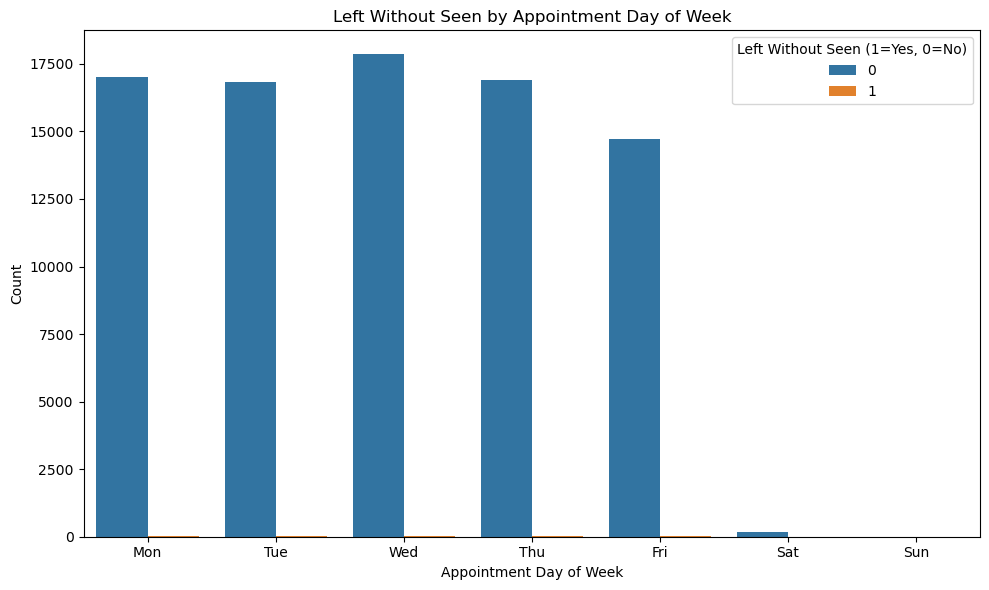

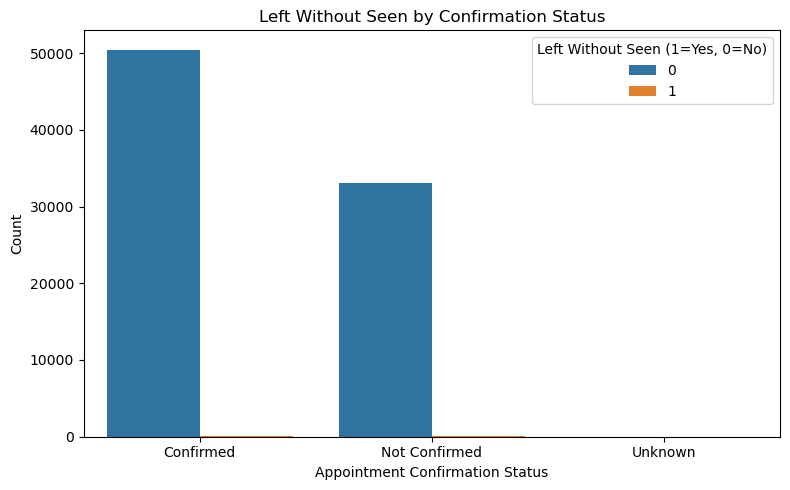

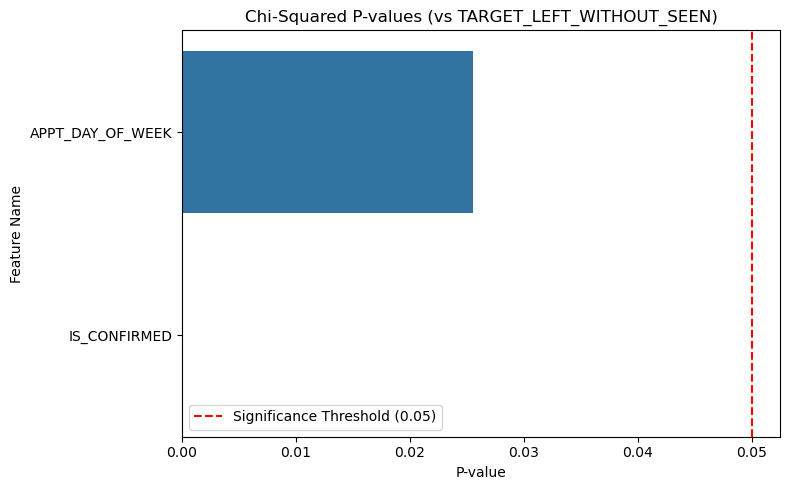


Feature store populated and visualizations generated for: C:\python_development\report_csv\feature_store.db


In [21]:
# --- 6. Visualize Feature Evaluations ---
print("\nGenerating feature evaluation visualizations...")

# Connect to the DB to fetch data for visualization
conn_viz = sqlite3.connect(sqlite_db_path)

# Load the engineered features data
try:
    df_viz_features = pd.read_sql_query(f"SELECT * FROM {feature_set_sqlite_table}", conn_viz)
except pd.io.sql.DatabaseError as e:
    print(f"Error reading feature set table {feature_set_sqlite_table}: {e}")
    df_viz_features = pd.DataFrame() # Create an empty DataFrame to avoid further errors

# Load the evaluation metrics (p-values for Chi2 tests)
try:
    df_viz_metrics = pd.read_sql_query(f"""
        SELECT fd.feature_name, fem.metric_name, fem.metric_value
        FROM feature_evaluation_metrics fem
        JOIN feature_definitions fd ON fem.feature_id = fd.feature_id
        WHERE fem.run_id = {evaluation_run_id} AND fem.metric_name = 'chi2_p_value'
    """, conn_viz)
except Exception as e: # Catch a broader exception if the run_id is not yet defined etc.
    print(f"Error reading evaluation metrics: {e}")
    df_viz_metrics = pd.DataFrame(columns=['feature_name', 'metric_name', 'metric_value'])


conn_viz.close() # Close visualization connection

target_col = 'TARGET_LEFT_WITHOUT_SEEN'
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
confirmed_map = {0: 'Not Confirmed', 1: 'Confirmed', np.nan: 'Unknown'}


if not df_viz_features.empty:
    # Visualization 1: APPT_DAY_OF_WEEK vs TARGET_LEFT_WITHOUT_SEEN
    if 'APPT_DAY_OF_WEEK' in df_viz_features.columns and target_col in df_viz_features.columns:
        plt.figure(figsize=(10, 6))
        # Map numeric day of week to string for better readability
        df_viz_features_copy = df_viz_features.copy() # Work on a copy to avoid SettingWithCopyWarning
        df_viz_features_copy['APPT_DAY_OF_WEEK_STR'] = df_viz_features_copy['APPT_DAY_OF_WEEK'].map(day_map)
        
        # Create the count plot / bar chart
        sns.countplot(x='APPT_DAY_OF_WEEK_STR', hue=target_col, data=df_viz_features_copy, order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
        plt.title('Left Without Seen by Appointment Day of Week')
        plt.xlabel('Appointment Day of Week')
        plt.ylabel('Count')
        plt.legend(title='Left Without Seen (1=Yes, 0=No)')
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping APPT_DAY_OF_WEEK visualization: Column(s) not found in the feature data.")

    # Visualization 2: IS_CONFIRMED vs TARGET_LEFT_WITHOUT_SEEN
    if 'IS_CONFIRMED' in df_viz_features.columns and target_col in df_viz_features.columns:
        plt.figure(figsize=(8, 5))
        df_viz_features_copy = df_viz_features.copy()
        df_viz_features_copy['IS_CONFIRMED_STR'] = df_viz_features_copy['IS_CONFIRMED'].map(confirmed_map)
        
        sns.countplot(x='IS_CONFIRMED_STR', hue=target_col, data=df_viz_features_copy, order=['Confirmed', 'Not Confirmed', 'Unknown'])
        plt.title('Left Without Seen by Confirmation Status')
        plt.xlabel('Appointment Confirmation Status')
        plt.ylabel('Count')
        plt.legend(title='Left Without Seen (1=Yes, 0=No)')
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping IS_CONFIRMED visualization: Column(s) not found in the feature data.")

else:
    print("Skipping feature distribution visualizations as feature data could not be loaded.")


# Visualization 3: Bar chart of Chi2 P-values
if not df_viz_metrics.empty:
    plt.figure(figsize=(8, 5))
    sns.barplot(x='metric_value', y='feature_name', data=df_viz_metrics)
    plt.title(f'Chi-Squared P-values (vs {target_variable_name})')
    plt.xlabel('P-value')
    plt.ylabel('Feature Name')
    plt.axvline(x=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Skipping P-value visualization as no metrics were loaded.")


feature_store.close() # Close the main connection now that visualizations are done
print(f"\nFeature store populated and visualizations generated for: {sqlite_db_path}")